This notebook demonstrates a test of refining the fundamental matrix using the slopes between keypoints.

In [37]:
import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('..'))

import unittest

from autocnet.examples import get_path
from autocnet.fileio.io_controlnetwork import to_isis
from autocnet.fileio.io_controlnetwork import write_filelist
from autocnet.graph.network import CandidateGraph
from autocnet.fileio import utils

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [38]:
serial_numbers = {'AS15-M-0295_SML.png': '1971-07-31T01:24:11.754',
                'AS15-M-0296_SML.png': '1971-07-31T01:24:36.970',
                'AS15-M-0297_SML.png': '1971-07-31T01:25:02.243',
                'AS15-M-0298_SML.png': '1971-07-31T01:25:27.457',
                'AS15-M-0299_SML.png': '1971-07-31T01:25:52.669',
                'AS15-M-0300_SML.png': '1971-07-31T01:26:17.923'}

for k, v in serial_numbers.items():
    serial_numbers[k] = 'APOLLO15/METRIC/{}'.format(v)

In [39]:
adjacency = get_path('two_image_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

cg.extract_features(method='sift', extractor_parameters={"nfeatures":500})
cg.match_features(k=2)

In [40]:
for source, destination, edge in cg.edges_iter(data=True):
    # Perform the symmetry check
    edge.symmetry_check()
    # Perform the ratio test
    edge.ratio_check(clean_keys=['symmetry'])

/home/kberry/anaconda3/envs/autocnet_new/lib/python3.5/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [41]:
cg.apply_func_to_edges("compute_fundamental_matrix", clean_keys=['symmetry', 'ratio'])

In [42]:
f = cg.edge[0][1].fundamental_matrix

In [43]:
df=utils.calculate_slope(f.x1, f.x2)
len(df.values.ravel())

79

In [44]:
f.mask[f.mask==True].equals(f.mask[f.mask])

True

In [45]:
nbr_inliers = 20
fp = np.array(np.random.standard_normal((nbr_inliers, 2)))  # inliers
static_F = np.array([[4, 0.5, 10], [0.25, 1, 5], [0.2, 0.1, 1]])
fph = np.hstack((fp, np.ones((nbr_inliers, 1))))
tp = static_F.dot(fph.T)
# normalize hom. coordinates
tp /= tp[-1, :np.newaxis]
df1 = pd.DataFrame(fp, columns=['x', 'y'])
df2 = pd.DataFrame(tp.T[:, :2], columns=['x', 'y'])

In [46]:
df1

,x,y
0,-0.218551,-0.184336
1,-0.600628,-0.645129
2,1.752817,1.577046
3,0.297779,-0.343874
4,-1.024672,-0.403529
5,0.825929,-1.127875
6,-0.683892,0.555461
7,1.355105,-0.001850
8,-1.859693,1.233740
9,-1.981953,2.080844


In [47]:
df2

,x,y
0,9.632209,5.076499
1,8.922328,5.156871
2,11.801477,4.651196
3,10.748653,4.614433
4,7.551945,5.750933
5,12.105472,3.875536
6,8.208999,5.860554
7,12.133348,4.199539
8,4.229369,7.677063
9,3.834708,8.113104


In [48]:
mask = df1.x > 0
mask

0     False
1     False
2      True
3      True
4     False
5      True
6     False
7      True
8     False
9     False
10    False
11    False
12     True
13    False
14     True
15     True
16    False
17    False
18     True
19    False
Name: x, dtype: bool

In [49]:
df1[mask]

,x,y
2,1.752817,1.577046
3,0.297779,-0.343874
5,0.825929,-1.127875
7,1.355105,-0.001850
12,0.415694,0.920262
14,0.449619,0.569440
15,0.250998,0.322701
18,1.128449,-0.913832


In [50]:
df2[mask]

,x,y
2,11.801477,4.651196
3,10.748653,4.614433
5,12.105472,3.875536
7,12.133348,4.199539
12,10.315919,5.126247
14,10.535824,4.954228
15,10.314692,4.975151
18,12.392487,3.851058


In [51]:
df1[mask] = df2[mask]

In [52]:
df1

,x,y
0,-0.218551,-0.184336
1,-0.600628,-0.645129
2,11.801477,4.651196
3,10.748653,4.614433
4,-1.024672,-0.403529
5,12.105472,3.875536
6,-0.683892,0.555461
7,12.133348,4.199539
8,-1.859693,1.233740
9,-1.981953,2.080844


In [53]:
#f.refine(values=utils.calculate_slope(f.x1, f.x2))

In [54]:
f.rollback()

In [55]:
f.mask

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12       True
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22       True
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
1970    False
1971    False
1972    False
1973    False
1974    False
1975    False
1976    False
1977    False
1978    False
1979    False
1980    False
1981    False
1982    False
1983    False
1984    False
1985    False
1986    False
1987    False
1988    False
1989    False
1990    False
1991    False
1992    False
1993    False
1994    False
1995    False
1996    False
1997    False
1998    False
1999    False
dtype: bool

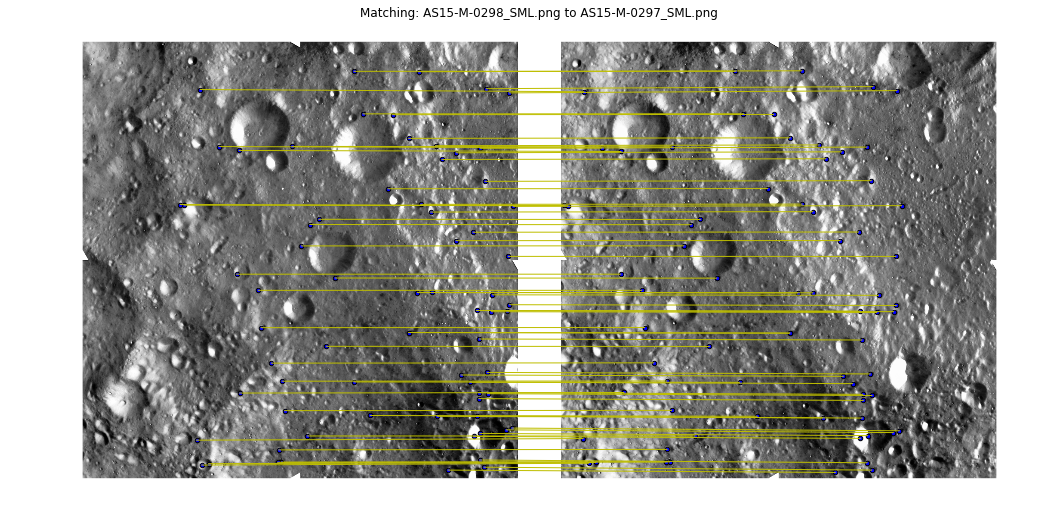

In [56]:
figsize(18,18)
fig, ax = plt.subplots(1,1)
ax = cg.edge[0][1].plot(clean_keys=['ratio', 'fundamental'], ax=ax)

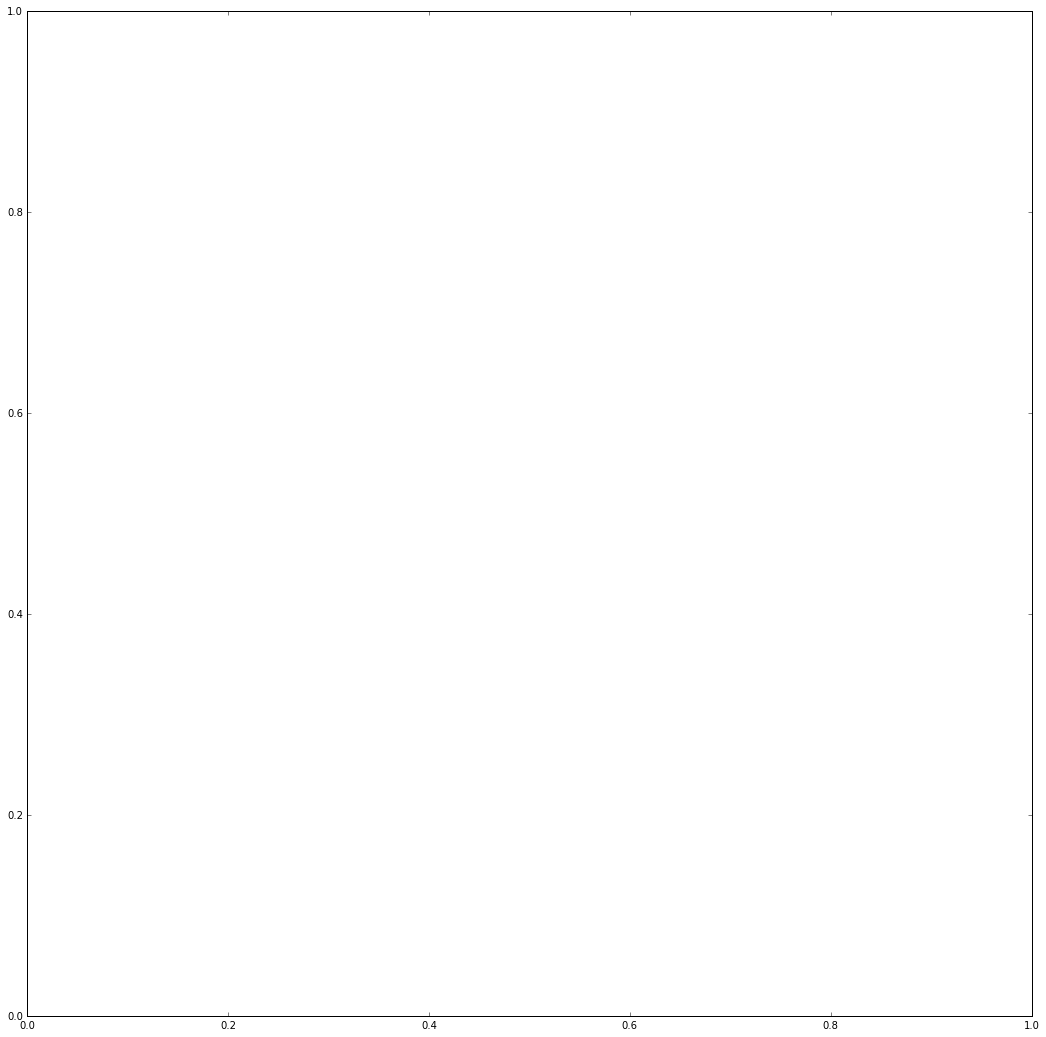

In [57]:
figsize(18,18)
fig, ax = plt.subplots(1,1)
#ax = cg.edge[0][2].plot(clean_keys=['ratio', 'symmetry', 'fundamental', 'subpixel'], ax=ax)